In [88]:
import numpy as np
import scipy.signal as ss
import librosa
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt

In [126]:
mixture, sr = sf.read("file.wav")
x = mixture.T
x = x[:-1]
n_channels, T = x.shape
n_sources = 3

In [122]:
for idx in range(n_channels):
    display(ipd.Audio(x[idx], rate=sr))

In [127]:
import matplotlib.pyplot as plt

# Initialization
channel = [[] for _ in range(7)]
fft_val = []

sr = 22050

# Do FFT for each channel
for i in range(7):
  fft_val.append(np.fft.fft(x[i]))
  Xf_mag = np.abs(np.fft.fft(x[i]))
  freqs = np.fft.fftfreq(len(Xf_mag), d=1.0/sr)
  for j in range (len(freqs)):
    data = (freqs[j],Xf_mag[j])
    channel[i].append(data)

1974.7414719820733


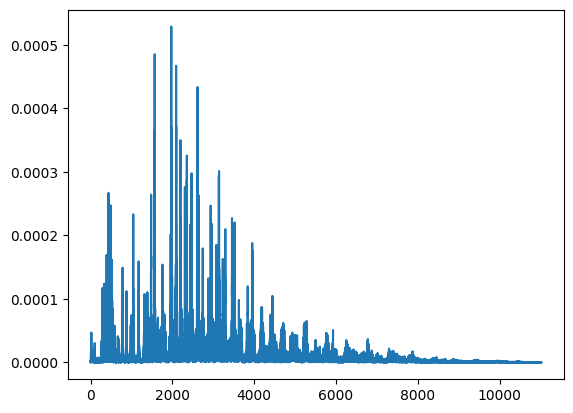

In [128]:
dt = 1/sr
t = np.arange(0, len(x[0])/sr, dt)
n = len(t)
xf = np.linspace(0.0, 1.0/(2.0*dt), n//2)
plt.plot(xf, 2.0/n * np.abs(fft_val[0][:n//2]))
print(xf[np.argmax(2.0/n * np.abs(fft_val[0][:n//2]))])
plt.show()

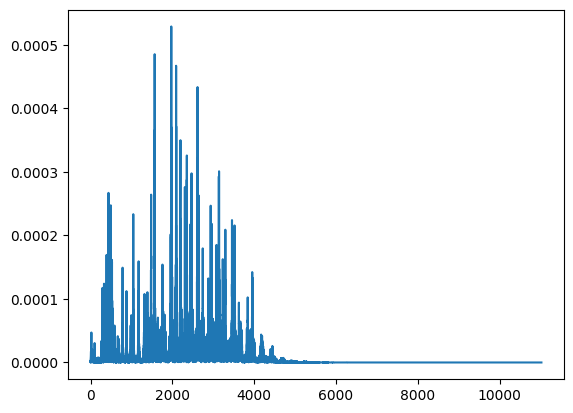

In [129]:
sos = ss.butter(10, 4000, 'low',output="sos", fs=sr)
audio = ss.sosfilt(sos, x[0])
y = np.fft.fft(audio)

dt = 1/sr
t = np.arange(0, len(audio)/sr, dt)
n = len(t)

xf = np.linspace(0.0, 1.0/(2.0*dt), n//2)
plt.plot(xf, 2.0/n * np.abs(y[:n//2]))

plt.show()

In [130]:
# To store which channel that the frequency coming from
freqs_max=[]

for i in range(len(freqs)):
  tmp = [channel[j][i][1] for j in range(7)]
  if np.max(tmp)<0.1:       # filtering out background noice
    freqs_max.append(-1)
  else:
    freqs_max.append(np.argmax(tmp))

# Assume we know number of source, find the channel that the source coming from
unique, counts = np.unique(freqs_max, return_counts=True)
unique = unique[1:]
counts = counts[1:]
df = dict(zip(unique, counts))
channel_source = []
for i in range(n_sources):
  max_value = max(df, key=df.get)
  channel_source.append(max_value)
  del df[max_value]

for i in range(len(freqs_max)):
  if freqs_max[i] == -1:
    pos = freqs_max[i]
    for j in range(7):
        fft_val[j][i] = 0
    continue
  pos = freqs_max[i]
  for j in range(7):
    if j != pos:
      fft_val[j][i] = 0

  fft_val[pos][i] = fft_val[pos][i]


# Apply low pass filter to filter out unnecessasry high frequency noise
filtered = []
for idx in range(1,7):
    s = np.fft.ifft(fft_val[idx])
    print("channel "+ str(idx))
    # b, a = ss.butter(2, 15000, 'low',analog=False, fs=sr)
    # filtered.append(ss.filtfilt(b, a, s))
    filtered.append(s)

    display(ipd.Audio(s, rate=sr))

channel 1


channel 2


channel 3


channel 4


channel 5


channel 6


In [132]:
# Combine the neighboring channel to enhance better quality of sound
for i in range(n_sources):
  required_pos = channel_source[i]
  if required_pos == 1:
    combined = filtered[5] + filtered[0] + filtered[1]
    if len(np.where(channel_source==6))==1:
        combined = combined - filtered[5]
    if len(np.where(channel_source==2))==1:
        combined = combined - filtered[1]

    print("Source "+str(i+1)+" from channel 1")
    display(ipd.Audio(combined, rate=sr))

  elif required_pos == 6:
    combined = filtered[0] + filtered[5]  + filtered[4]
    if len(np.where(channel_source==1))==1:
        combined = combined - filtered[0]
    if len(np.where(channel_source==5))==1:
        combined = combined - filtered[4]
    print("Source "+str(i+1)+" from channel 6")
    display(ipd.Audio(combined, rate=sr))

  else:
    print("Source "+str(i+1)+ " from channel "+str(required_pos))
    combined = filtered[required_pos-2] + filtered[required_pos-1]  + filtered[required_pos]
    if len(np.where(channel_source==(required_pos-1)))==1:
        combined = combined - filtered[required_pos-2]
    if len(np.where(channel_source==(required_pos+1)))==1:
        combined = combined - filtered[required_pos]
    # combined = filtered[required_pos-1]*2

    display(ipd.Audio(combined, rate=sr))

Source 1 from channel 4


Source 2 from channel 1


Source 3 from channel 6


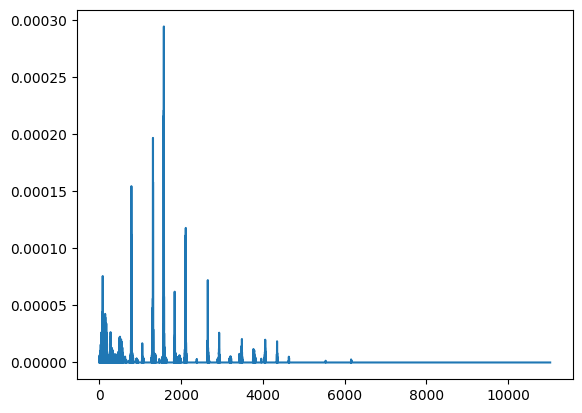

In [118]:
# sos = ss.butter(10, 4000, 'low',output="sos", fs=sr)
# audio = ss.sosfilt(sos, x[0])
y = np.fft.fft(combined)

dt = 1/sr
t = np.arange(0, len(combined)/sr, dt)
n = len(t)

xf = np.linspace(0.0, 1.0/(2.0*dt), n//2)
plt.plot(xf, 2.0/n * np.abs(y[:n//2]))

plt.show()

In [143]:
new_audio = x+combined
display(ipd.Audio(new_audio, rate=sr))